# 07/29/2024
Fiona Zheng

In [1]:
import pandas as pd
import numpy as np
import holidays
import warnings
warnings.filterwarnings('ignore')

In [192]:
df = pd.read_csv(r'load_scada_actual.csv')
print(df.columns)

Index(['load_name', 'timestamp', 'lmp', 'tag_actual', 'tag_scheduled',
       'netload', 'netload_source', 'gross_load', 'date_local', 'he_local',
       'tz', 'lastest_update_utc'],
      dtype='object')


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215824 entries, 0 to 215823
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   load_name           215824 non-null  object 
 1   timestamp           215824 non-null  object 
 2   lmp                 22317 non-null   float64
 3   tag_actual          22355 non-null   float64
 4   tag_scheduled       2 non-null       float64
 5   netload             209132 non-null  float64
 6   netload_source      209132 non-null  object 
 7   gross_load          46078 non-null   float64
 8   date_local          215824 non-null  object 
 9   he_local            215824 non-null  int64  
 10  tz                  215824 non-null  object 
 11  lastest_update_utc  209132 non-null  object 
dtypes: float64(5), int64(1), object(6)
memory usage: 19.8+ MB


In [194]:
df.drop(columns = ['lmp', 'tag_actual', 'tag_scheduled', 'netload', 'netload_source', 'date_local', 'he_local',
       'tz', 'lastest_update_utc'], inplace = True)
df

,load_name,timestamp,gross_load
0,KCEC,2024-07-30 19:00:00+00:00,NaN
1,KCEC,2024-07-30 20:00:00+00:00,NaN
2,KCEC,2024-07-30 21:00:00+00:00,NaN
3,KCEC,2024-07-31 01:00:00+00:00,NaN
4,KCEC,2024-07-31 02:00:00+00:00,NaN
...,...,...,...
215819,KCEC,2020-04-14 05:00:00+00:00,NaN
215820,KCEC,2019-11-21 06:00:00+00:00,NaN
215821,KCEC,2019-11-20 06:00:00+00:00,NaN
215822,KCEC,2019-11-06 06:00:00+00:00,NaN


In [195]:
df.load_name.value_counts()

load_name
HCE            46679
KCEC           44524
JICARILLA      44135
ACOMA          27393
RATON          25131
DMEA           21270
AZTEC           2698
UNITED PSCO     2009
UNITED WACM     1985
Name: count, dtype: int64

In [196]:
# non_null_values_count  = df[~df['actual_gross_load'].isna()].groupby('load_name').size()
# most_non_null_value_group = non_null_values_count.idxmax()
# print(most_non_null_value_group)
# df = df[df['load_name'] == most_non_null_value_group]

df = df[df['load_name'] == 'DMEA']
df.drop(columns = ['load_name'], inplace = True)
# actual gross load is empty for HCE

In [197]:
df

,timestamp,gross_load
47,2024-07-30 19:00:00+00:00,83.172017
48,2024-07-30 20:00:00+00:00,82.522983
49,2024-07-30 21:00:00+00:00,93.267317
50,2024-07-30 22:00:00+00:00,100.338150
51,2024-07-30 23:00:00+00:00,92.407567
...,...,...
209662,2024-07-26 05:00:00+00:00,66.277650
209663,2024-07-27 05:00:00+00:00,65.818617
209664,2024-07-28 05:00:00+00:00,64.141883
209665,2024-07-29 05:00:00+00:00,59.904300


In [198]:
df = df.dropna() 
print(len(df))

21270


In [199]:
# sort by timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by = 'timestamp')
# split timestamp into month date and time
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['season'] = ['winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'fall' for x in df['month']]
df['date'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['dow'] = df['timestamp'].dt.dayofweek

In [200]:
print(df.columns)
df.info()

Index(['timestamp', 'gross_load', 'year', 'month', 'season', 'date', 'hour',
       'dow'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 21270 entries, 109752 to 63
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   timestamp   21270 non-null  datetime64[ns, UTC]
 1   gross_load  21270 non-null  float64            
 2   year        21270 non-null  int32              
 3   month       21270 non-null  int32              
 4   season      21270 non-null  object             
 5   date        21270 non-null  int32              
 6   hour        21270 non-null  int32              
 7   dow         21270 non-null  int32              
dtypes: datetime64[ns, UTC](1), float64(1), int32(5), object(1)
memory usage: 1.1+ MB


## Adding whether data

In [201]:
weather_df = pd.read_csv(r'DMEA_weather_data.csv')
weather_df

,index,temperature,solar_radiation,cloud_cover,humidity,wind_speed
0,2015-01-01 00:00:00+00:00,18.579321,0.0,30.915419,0.000000,2.423029
1,2015-01-01 01:00:00+00:00,15.854053,0.0,3.262689,0.000000,2.458667
2,2015-01-01 02:00:00+00:00,13.142407,0.0,1.875000,0.000000,2.116607
3,2015-01-01 03:00:00+00:00,12.213239,0.0,5.447345,0.000000,3.115575
4,2015-01-01 04:00:00+00:00,12.233124,0.0,41.087280,0.000000,1.917479
...,...,...,...,...,...,...
81798,2024-07-31 08:00:00+00:00,66.751624,0.0,0.000000,16.093412,4.421155
81799,2024-07-31 09:00:00+00:00,65.298682,0.0,0.000000,16.953800,3.711957
81800,2024-07-31 10:00:00+00:00,62.027557,0.0,0.000000,21.734526,3.720699
81801,2024-07-31 11:00:00+00:00,59.840289,0.0,0.000000,23.930729,3.353332


In [202]:
weather_df['timestamp'] = pd.to_datetime(weather_df['index'])
weather_df = weather_df.sort_values(by = 'timestamp')
# merge weather data with df
df = pd.merge(df, weather_df, on = 'timestamp', how = 'left')
#drop index column
df.drop(columns = ['index'], inplace = True)
df

,timestamp,gross_load,year,month,season,date,hour,dow,temperature,solar_radiation,cloud_cover,humidity,wind_speed
0,2021-10-21 18:00:00+00:00,58.728000,2021,10,fall,21,18,3,53.693549,656.685242,67.000000,32.073475,1.991841
1,2021-10-21 19:00:00+00:00,62.769083,2021,10,fall,21,19,3,57.486029,710.514648,11.611272,30.586985,1.543698
2,2021-10-21 20:00:00+00:00,62.078933,2021,10,fall,21,20,3,60.400208,622.538208,59.856133,26.052521,1.782106
3,2021-10-21 21:00:00+00:00,63.153767,2021,10,fall,21,21,3,62.212457,577.231445,2.051746,21.712488,2.218037
4,2021-10-21 22:00:00+00:00,65.232000,2021,10,fall,21,22,3,62.565063,421.572235,0.000000,19.294811,2.095834
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21265,2024-07-31 07:00:00+00:00,55.465217,2024,7,summer,31,7,2,68.434839,0.000000,0.000000,16.169823,4.481148
21266,2024-07-31 08:00:00+00:00,54.373650,2024,7,summer,31,8,2,66.751624,0.000000,0.000000,16.093412,4.421155
21267,2024-07-31 09:00:00+00:00,50.037567,2024,7,summer,31,9,2,65.298682,0.000000,0.000000,16.953800,3.711957
21268,2024-07-31 10:00:00+00:00,51.308583,2024,7,summer,31,10,2,62.027557,0.000000,0.000000,21.734526,3.720699


# EDA

In [203]:
df.describe()

,gross_load,year,month,date,hour,dow,temperature,solar_radiation,cloud_cover,humidity,wind_speed
count,21270.000000,21270.000000,21270.000000,21270.000000,21270.000000,21270.000000,21080.000000,21080.000000,21080.000000,21080.000000,21080.000000
mean,71.415080,2022.856041,6.167936,15.814151,11.498213,2.999060,51.676603,215.102238,31.045525,44.155939,2.856401
std,17.376217,0.790393,3.387424,9.042157,6.930237,1.995811,24.976445,311.713491,40.947195,22.257775,1.704189
min,0.387917,2021.000000,1.000000,1.000000,0.000000,0.000000,-459.400000,0.000000,0.000000,0.000000,0.000000
25%,56.964921,2022.000000,3.000000,8.000000,5.000000,1.000000,35.254755,0.000000,0.000000,25.619880,1.739419
50%,70.474217,2023.000000,6.000000,16.000000,11.000000,3.000000,50.103024,0.000000,2.547412,42.610350,2.617153
75%,85.027404,2023.000000,9.000000,24.000000,18.000000,5.000000,66.894968,395.210297,73.662273,61.035764,3.491418
max,122.336500,2024.000000,12.000000,31.000000,23.000000,6.000000,1090.016852,1090.493042,200.000000,165.550156,14.999789


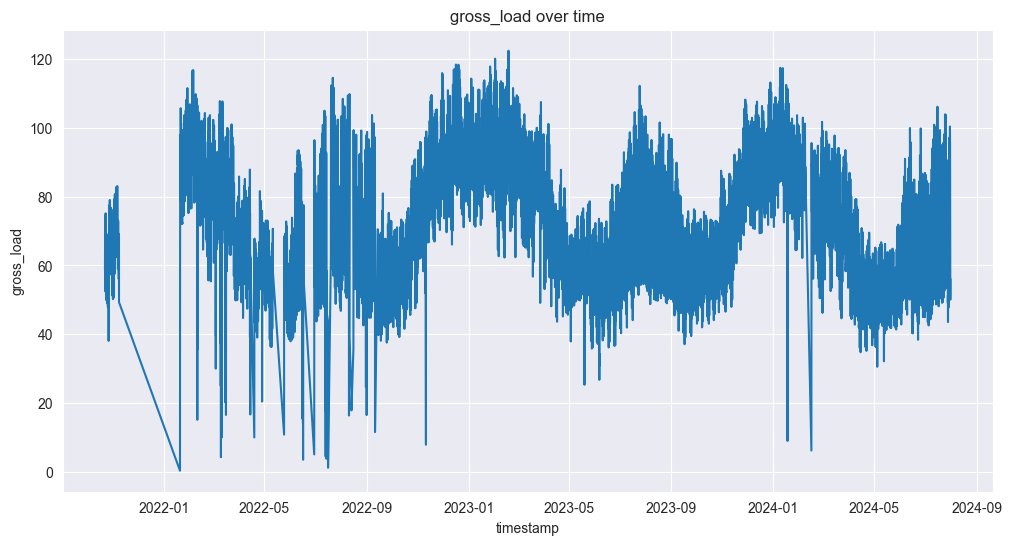

In [204]:
import matplotlib.pyplot as plt

# basic plots for actual_gross_load with x being timestamp
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['gross_load'])
plt.title('gross_load over time')
plt.xlabel('timestamp')
plt.ylabel('gross_load')
plt.show()

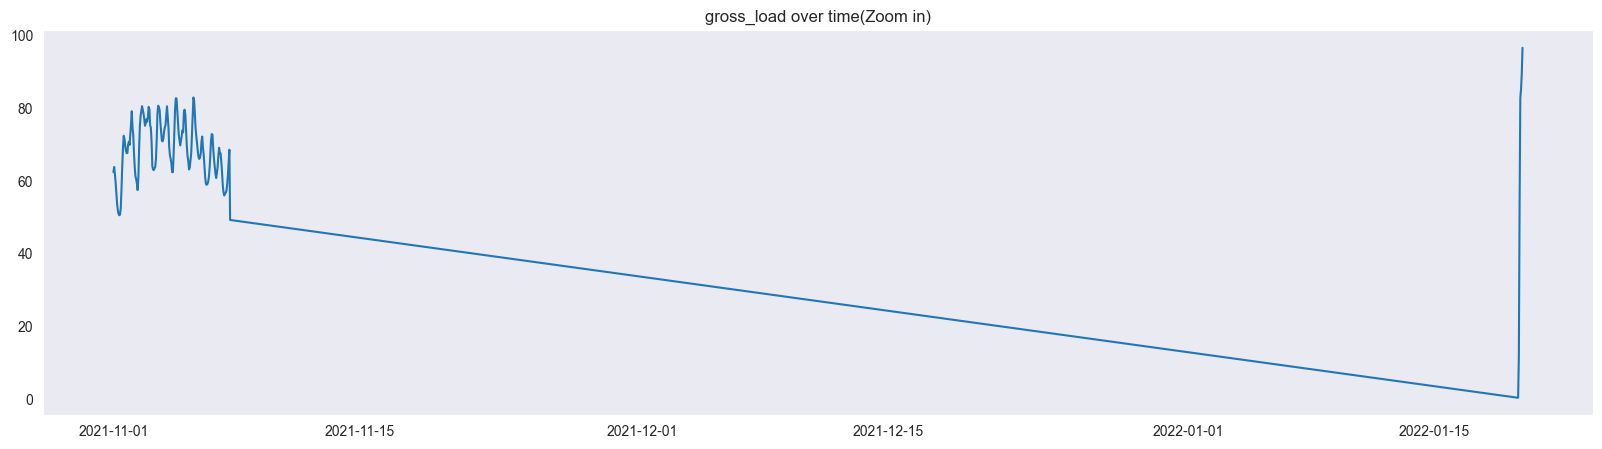

In [205]:
from datetime import datetime
from pytz import timezone
df_tmp = df.copy()
df_tmp['timestamp'] = pd.to_datetime(df_tmp['timestamp'])
df_tmp.set_index('timestamp', inplace=True)
df_tmp = df_tmp.loc[
    (df_tmp.index >= datetime(2021, 11, 1, tzinfo=timezone('UTC')))
    & (df_tmp.index <= datetime(2022, 1, 20, tzinfo=timezone('UTC')))
]

plt.figure(figsize=(20, 5))
plt.plot(df_tmp["gross_load"])
plt.title('gross_load over time(Zoom in)')
plt.grid()
plt.show()

In [206]:
# 2021-10-25 16:00:00+00:00
# Convert the 'timestamp' column to datetime if it's not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Filter the DataFrame based on the timestamp range
start_date = '2021-11-07 00:00:00+00:00'
end_date = '2022-01-20 00:00:00+00:00'

filtered_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]
filtered_df

,timestamp,gross_load,year,month,season,date,hour,dow,temperature,solar_radiation,cloud_cover,humidity,wind_speed
390,2021-11-07 00:00:00+00:00,69.180633,2021,11,fall,7,0,6,63.215289,0.000000,0.000000,15.280973,2.155310
391,2021-11-07 01:00:00+00:00,67.707917,2021,11,fall,7,1,6,57.816663,0.000000,0.000000,20.305021,1.738493
392,2021-11-07 02:00:00+00:00,67.650133,2021,11,fall,7,2,6,54.437982,0.000000,7.079650,25.347755,1.917852
393,2021-11-07 03:00:00+00:00,65.401633,2021,11,fall,7,3,6,51.321106,0.000000,0.198315,28.338402,2.533162
394,2021-11-07 04:00:00+00:00,62.492350,2021,11,fall,7,4,6,49.167181,0.000000,0.000000,24.261620,2.977973
395,2021-11-07 05:00:00+00:00,58.869017,2021,11,fall,7,5,6,48.456586,0.000000,0.000000,24.776318,2.108555
396,2021-11-07 06:00:00+00:00,56.914250,2021,11,fall,7,6,6,45.301257,0.000000,0.000000,30.192045,2.732633
397,2021-11-07 07:00:00+00:00,56.057133,2021,11,fall,7,7,6,44.525677,0.000000,0.000000,31.444820,2.964890
398,2021-11-07 08:00:00+00:00,56.431783,2021,11,fall,7,8,6,43.978394,0.000000,0.000000,28.804569,2.931232
399,2021-11-07 09:00:00+00:00,56.832983,2021,11,fall,7,9,6,43.475824,0.000000,0.000000,28.725506,2.464126


In [207]:
# start from 2022-01-19 18:00:00+00:00
df = df[df['timestamp'] >= '2022-01-19 18:00:00+00:00']

In [209]:
# start and end date 
print(df['timestamp'].min())
print(df['timestamp'].max())

2022-01-19 18:00:00+00:00
2024-07-31 11:00:00+00:00


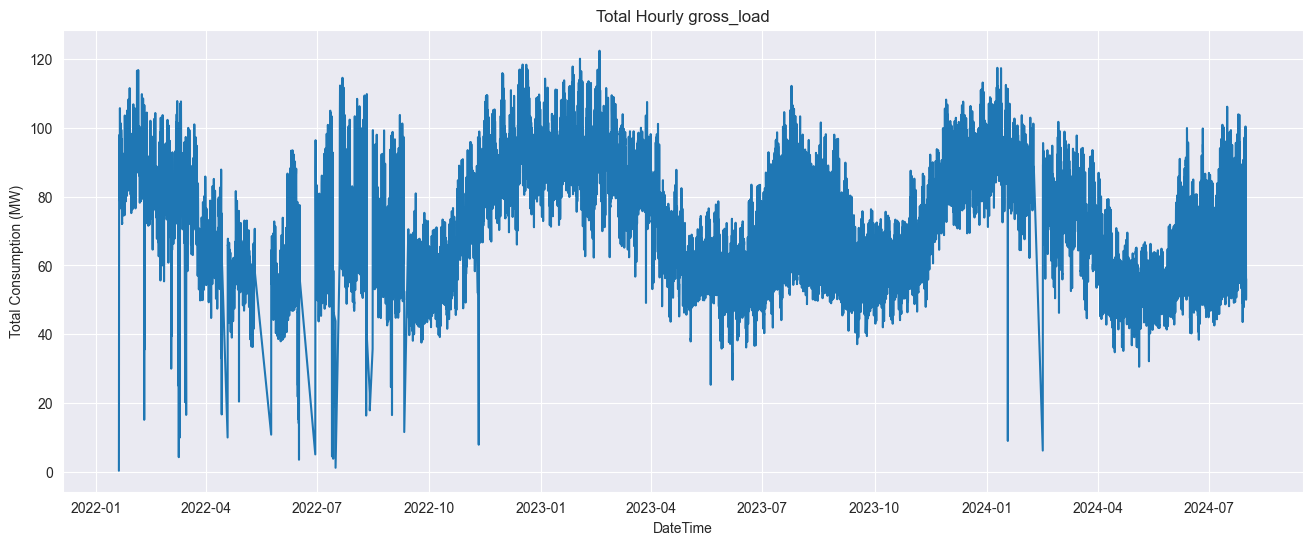

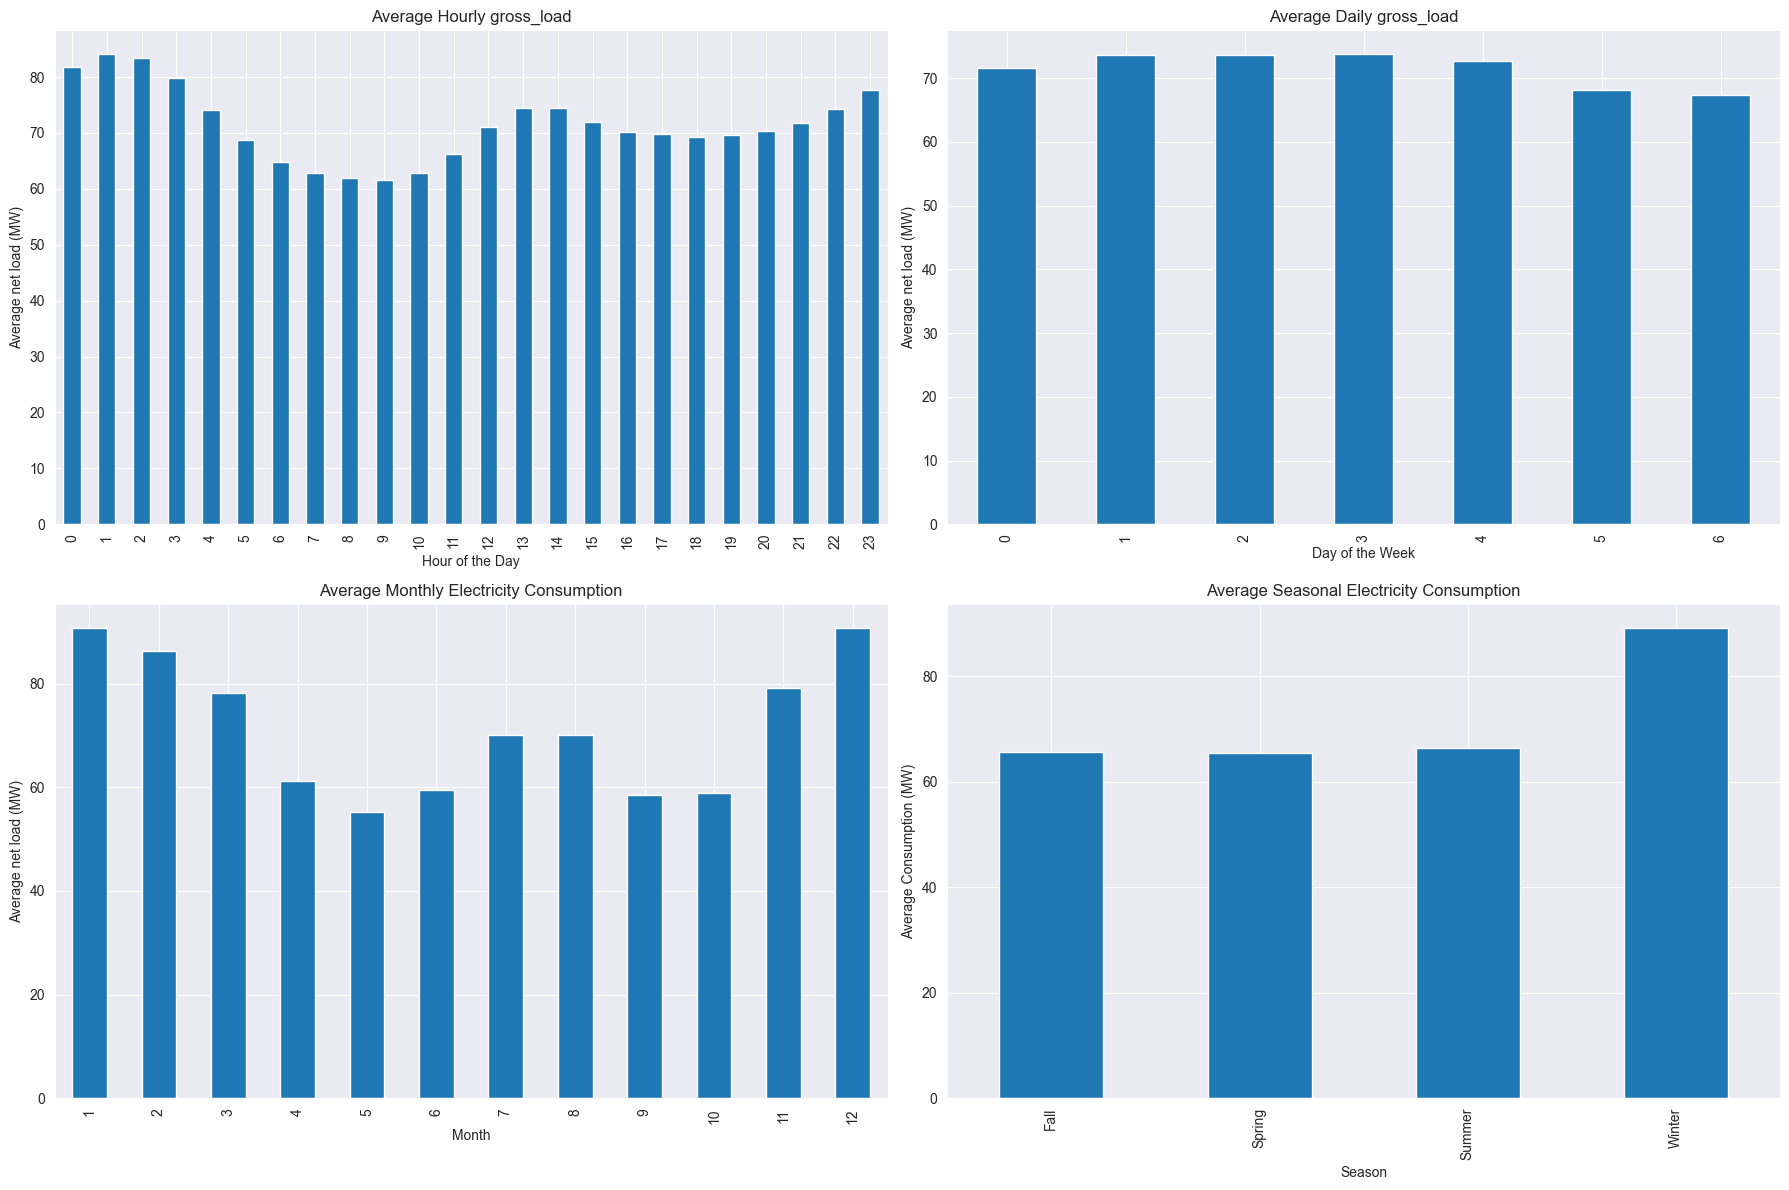

## Data preprocessing

In [211]:
# feature engineering
df['month_sin'] = np.sin((df['month'] - 1) * (2. * np.pi / 12))
df['month_cos'] = np.cos((df['month'] - 1) * (2. * np.pi / 12))
df['day_sin'] = np.sin((df['date'] - 1) * (2. * np.pi / 31))
df['day_cos'] = np.cos((df['date'] - 1) * (2. * np.pi / 31))
df['hour_sin'] = np.sin(df['hour'] * (2. * np.pi / 24))
df['hour_cos'] = np.cos(df['hour'] * (2. * np.pi / 24))
df['dow_sin'] = np.sin(df['dow'] * (2. * np.pi / 7))
df['dow_cos'] = np.cos(df['dow'] * (2. * np.pi / 7))

# holiday feature
us_holidays = holidays.US()
df['is_holiday'] = df['timestamp'].apply(lambda x: x in us_holidays)
df['is_holiday'] = df['is_holiday'].astype(int)

Number of outliers: 418


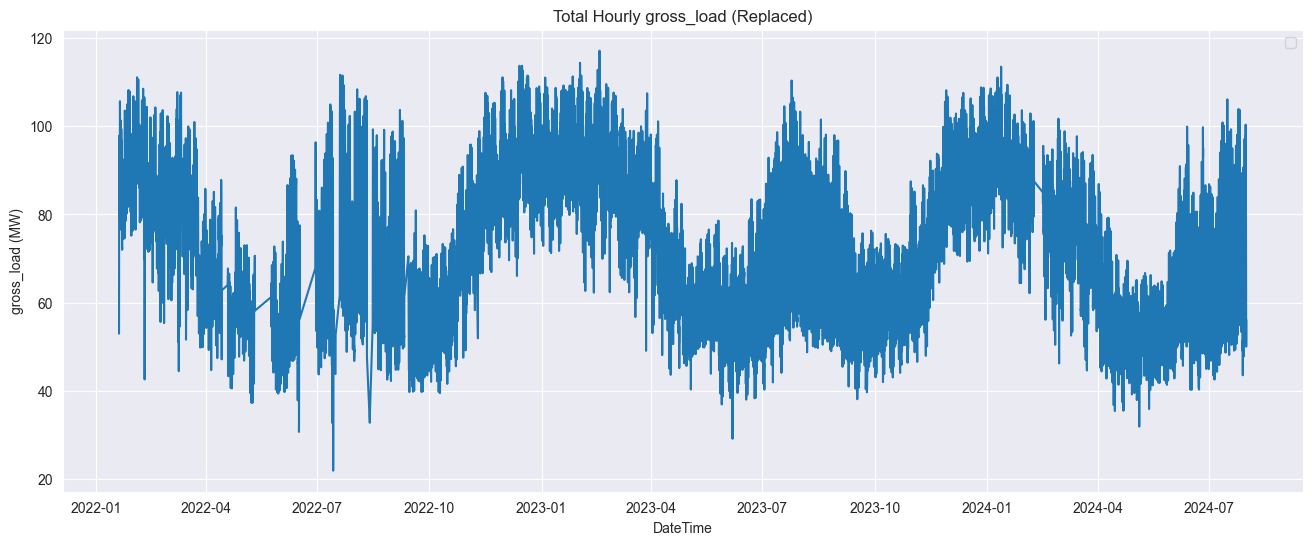

In [212]:
# define the outliers as the values outside of the 0.5% and 99.5% quantiles
# replace the outlier values as the average of the previous day and the next day
def replace_outliers_with_avg(s):
    lower_bound = s.quantile(0.01)
    upper_bound = s.quantile(0.99)
    outliers = (s < lower_bound) | (s > upper_bound)
    
    for idx in s[outliers].index:
        if idx == 0 or idx == len(s) - 1:
            # directly drop the first and last value
            s.at[idx] = np.nan
            continue
        prev_val = s.iloc[idx - 1]
        next_val = s.iloc[idx + 1]
        s.at[idx] = (prev_val + next_val) / 2
    return s

# reset index 
df.reset_index(drop=True, inplace=True)
# Assuming df is your DataFrame and 'timestamp' and 'gross_load' are the relevant columns
df['gross_load_replaced'] = replace_outliers_with_avg(df['gross_load'].copy())

# Number of outliers
print(f'Number of outliers: {df[df["gross_load"] != df["gross_load_replaced"]].shape[0]}')

# Plot the replaced 'gross_load_replaced'
plt.figure(figsize=(16, 6))
plt.plot(df['timestamp'], df['gross_load_replaced'])
plt.xlabel('DateTime')
plt.ylabel('gross_load (MW)')
plt.title('Total Hourly gross_load (Replaced)')
plt.legend()
plt.show()

In [ ]:
# 

In [213]:
# 3 days shift
df_ = df.copy()

# Calculate the timestamp 3 days ago
df_['timestamp_3d'] = df_['timestamp'] - pd.Timedelta(days=3)
df_['timestamp_3d'] = df_['timestamp_3d'].dt.floor('H')

# Rename columns to avoid duplication
df_3d = df_[['timestamp', 'gross_load_replaced']].copy()
df_3d.columns = ['timestamp_3d', 'gross_load_replaced_3d']

# Merge the 3 days ago data with the original data
df_merged = df_.merge(df_3d, left_on='timestamp_3d', right_on='timestamp_3d', how='left')

# Display information about the merged DataFrame
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20864 entries, 0 to 20863
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   timestamp               20864 non-null  datetime64[ns, UTC]
 1   gross_load              20864 non-null  float64            
 2   year                    20864 non-null  int32              
 3   month                   20864 non-null  int32              
 4   season                  20864 non-null  object             
 5   date                    20864 non-null  int32              
 6   hour                    20864 non-null  int32              
 7   dow                     20864 non-null  int32              
 8   temperature             20674 non-null  float64            
 9   solar_radiation         20674 non-null  float64            
 10  cloud_cover             20674 non-null  float64            
 11  humidity                20674 non-null  f

In [214]:
# print out where gross_load_3d is null
df_merged[df_merged['gross_load_replaced_3d'].isnull()]

,timestamp,gross_load,year,month,season,date,hour,dow,temperature,solar_radiation,...,day_sin,day_cos,hour_sin,hour_cos,dow_sin,dow_cos,is_holiday,gross_load_replaced,timestamp_3d,gross_load_replaced_3d
0,2022-01-19 18:00:00+00:00,0.387917,2022,1,winter,19,18,2,36.182660,370.082306,...,-0.485302,-0.874347,-1.000000,-1.836970e-16,0.974928,-0.222521,0,NaN,2022-01-16 18:00:00+00:00,NaN
1,2022-01-19 19:00:00+00:00,11.835600,2022,1,winter,19,19,2,38.687543,257.615509,...,-0.485302,-0.874347,-0.965926,2.588190e-01,0.974928,-0.222521,0,NaN,2022-01-16 19:00:00+00:00,NaN
2,2022-01-19 20:00:00+00:00,52.997533,2022,1,winter,19,20,2,40.741547,547.308533,...,-0.485302,-0.874347,-0.866025,5.000000e-01,0.974928,-0.222521,0,52.997533,2022-01-16 20:00:00+00:00,NaN
3,2022-01-19 21:00:00+00:00,82.889467,2022,1,winter,19,21,2,41.942792,502.412262,...,-0.485302,-0.874347,-0.707107,7.071068e-01,0.974928,-0.222521,0,82.889467,2022-01-16 21:00:00+00:00,NaN
4,2022-01-19 22:00:00+00:00,85.338300,2022,1,winter,19,22,2,42.406305,373.952393,...,-0.485302,-0.874347,-0.500000,8.660254e-01,0.974928,-0.222521,0,85.338300,2022-01-16 22:00:00+00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16930,2024-02-18 14:00:00+00:00,88.727450,2024,2,winter,18,14,6,23.177045,0.000000,...,-0.299363,-0.954139,-0.500000,-8.660254e-01,-0.781831,0.623490,0,88.727450,2024-02-15 14:00:00+00:00,NaN
16931,2024-02-18 15:00:00+00:00,91.176800,2024,2,winter,18,15,6,25.878967,18.841860,...,-0.299363,-0.954139,-0.707107,-7.071068e-01,-0.781831,0.623490,0,91.176800,2024-02-15 15:00:00+00:00,NaN
16932,2024-02-18 16:00:00+00:00,88.894117,2024,2,winter,18,16,6,31.713586,93.224030,...,-0.299363,-0.954139,-0.866025,-5.000000e-01,-0.781831,0.623490,0,88.894117,2024-02-15 16:00:00+00:00,NaN
16933,2024-02-18 17:00:00+00:00,84.898150,2024,2,winter,18,17,6,35.545178,22.514320,...,-0.299363,-0.954139,-0.965926,-2.588190e-01,-0.781831,0.623490,0,84.898150,2024-02-15 17:00:00+00:00,NaN


In [215]:
# df_merged drop nan
df_merged.dropna(inplace=True)
df_merged.columns

Index(['timestamp', 'gross_load', 'year', 'month', 'season', 'date', 'hour',
       'dow', 'temperature', 'solar_radiation', 'cloud_cover', 'humidity',
       'wind_speed', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_holiday',
       'gross_load_replaced', 'timestamp_3d', 'gross_load_replaced_3d'],
      dtype='object')

In [287]:
# Normalize the data and convert to time series data
from sklearn.preprocessing import MinMaxScaler

df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
df_merged = df_merged.sort_values(by = 'timestamp')
# features and target
df_model = df_merged[['gross_load_replaced', 'gross_load_replaced_3d', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'temperature', 'solar_radiation', 'cloud_cover', 'humidity',
       'wind_speed']]


features = ['gross_load_replaced_3d', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'temperature', 'solar_radiation', 'cloud_cover', 'humidity','wind_speed']
features_to_scale = ['gross_load_replaced_3d', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'temperature', 'solar_radiation', 'cloud_cover', 'humidity','wind_speed']
target_column = ['gross_load_replaced']
#non_scaled_features = ['is_holiday']

columns_to_scale = features_to_scale + target_column

# Scale the feature columns and target column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df_model[columns_to_scale])
LSTM_df = pd.DataFrame(scaled_df, columns=columns_to_scale, index=df_model.index)
LSTM_df

,gross_load_replaced_3d,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,dow_sin,dow_cos,temperature,solar_radiation,cloud_cover,humidity,wind_speed,gross_load_replaced
74,0.270997,0.5,1.0,0.050521,0.277951,0.066987,0.750000,0.000000,0.356896,0.320563,0.257023,0.500268,0.441337,0.039796,0.565371
75,0.610973,0.5,1.0,0.050521,0.277951,0.146447,0.853553,0.000000,0.356896,0.321561,0.463028,0.126753,0.409061,0.008701,0.550908
76,0.638824,0.5,1.0,0.050521,0.277951,0.250000,0.933013,0.000000,0.356896,0.322607,0.350211,0.019385,0.388261,0.033653,0.553307
77,0.687832,0.5,1.0,0.050521,0.277951,0.370590,0.982963,0.000000,0.356896,0.322655,0.193267,0.003273,0.350356,0.129865,0.587788
78,0.768096,0.5,1.0,0.015339,0.373065,0.500000,1.000000,0.099031,0.801938,0.321121,0.026591,0.000000,0.352669,0.114282,0.678449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20859,0.292012,0.5,0.0,0.399221,0.989739,0.982963,0.370590,1.000000,0.356896,0.340667,0.000000,0.000000,0.097673,0.298747,0.352399
20860,0.259310,0.5,0.0,0.399221,0.989739,0.933013,0.250000,1.000000,0.356896,0.339580,0.000000,0.000000,0.097212,0.294748,0.340929
20861,0.234447,0.5,0.0,0.399221,0.989739,0.853553,0.146447,1.000000,0.356896,0.338643,0.000000,0.000000,0.102409,0.247467,0.295365
20862,0.225927,0.5,0.0,0.399221,0.989739,0.750000,0.066987,1.000000,0.356896,0.336531,0.000000,0.000000,0.131287,0.248050,0.308721


In [288]:
# Split the data into k-fold and out of sample
LSTM_df_ofs = LSTM_df.iloc[-2000:, :]
LSTM_df = LSTM_df.iloc[:-2000, :]

In [289]:
# split into train and test sets
values = LSTM_df.values
n_train_hours = 365 * 36
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]  # x: All columns except the last,  y: The last column
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [number of samples, timesteps, Number of features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13140, 1, 14) (13140,) (4897, 1, 14) (4897,)


In [290]:
LSTM_df.columns

Index(['gross_load_replaced_3d', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'temperature',
       'solar_radiation', 'cloud_cover', 'humidity', 'wind_speed',
       'gross_load_replaced'],
      dtype='object')

Epoch 1/50
548/548 - 2s - 4ms/step - loss: 0.1200 - mae: 0.1200 - mape: 28107.0020 - mse: 0.0296 - val_loss: 0.1588 - val_mae: 0.1588 - val_mape: 28.3596 - val_mse: 0.0358 - learning_rate: 0.0010
Epoch 2/50
548/548 - 1s - 2ms/step - loss: 0.0879 - mae: 0.0879 - mape: 27566.5527 - mse: 0.0127 - val_loss: 0.1492 - val_mae: 0.1492 - val_mape: 26.4470 - val_mse: 0.0317 - learning_rate: 0.0010
Epoch 3/50
548/548 - 1s - 2ms/step - loss: 0.0834 - mae: 0.0834 - mape: 29678.2832 - mse: 0.0115 - val_loss: 0.1588 - val_mae: 0.1588 - val_mape: 27.5884 - val_mse: 0.0354 - learning_rate: 0.0010
Epoch 4/50
548/548 - 1s - 1ms/step - loss: 0.0801 - mae: 0.0801 - mape: 29038.8398 - mse: 0.0108 - val_loss: 0.1487 - val_mae: 0.1487 - val_mape: 26.0129 - val_mse: 0.0312 - learning_rate: 0.0010
Epoch 5/50
548/548 - 1s - 1ms/step - loss: 0.0765 - mae: 0.0765 - mape: 24599.5098 - mse: 0.0098 - val_loss: 0.1400 - val_mae: 0.1400 - val_mape: 24.5705 - val_mse: 0.0278 - learning_rate: 0.0010
Epoch 6/50
548/548 -

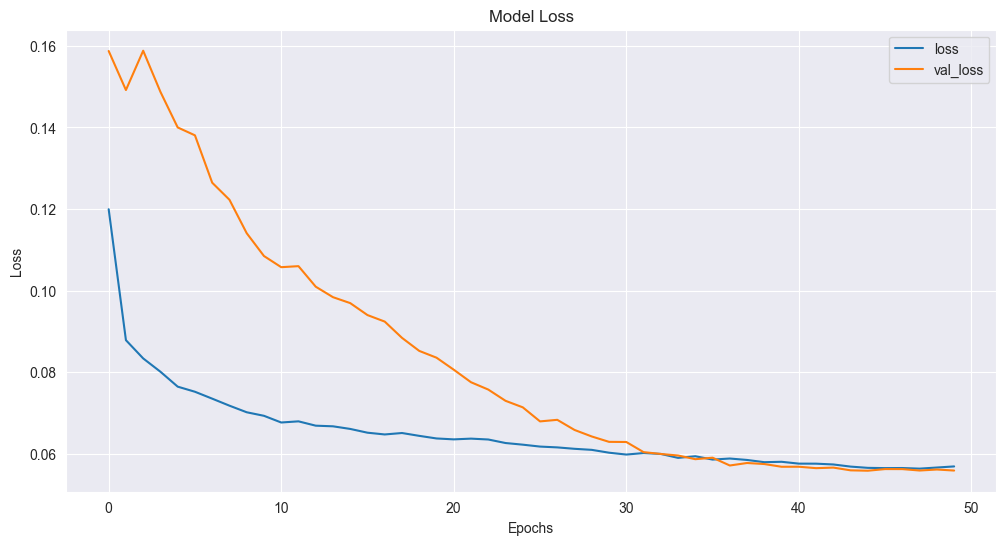

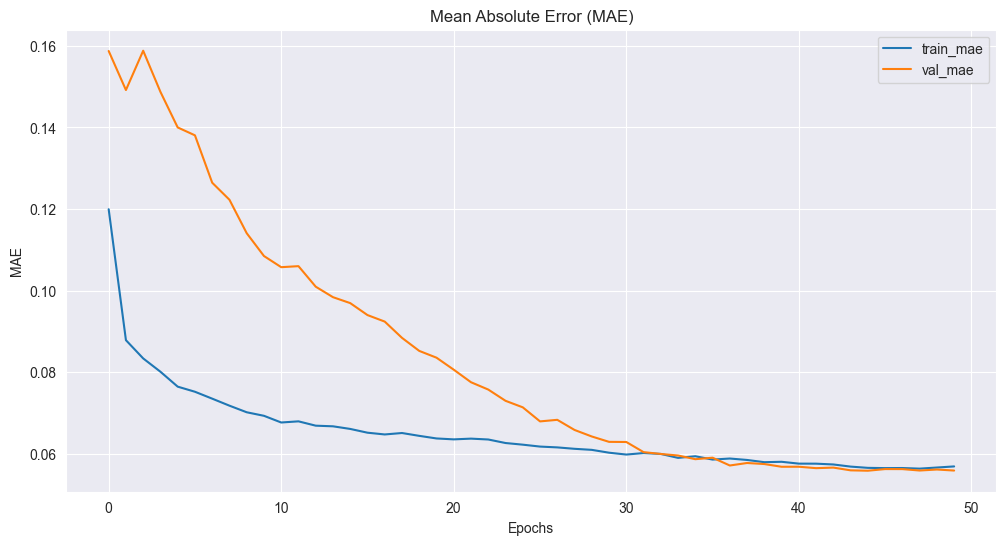

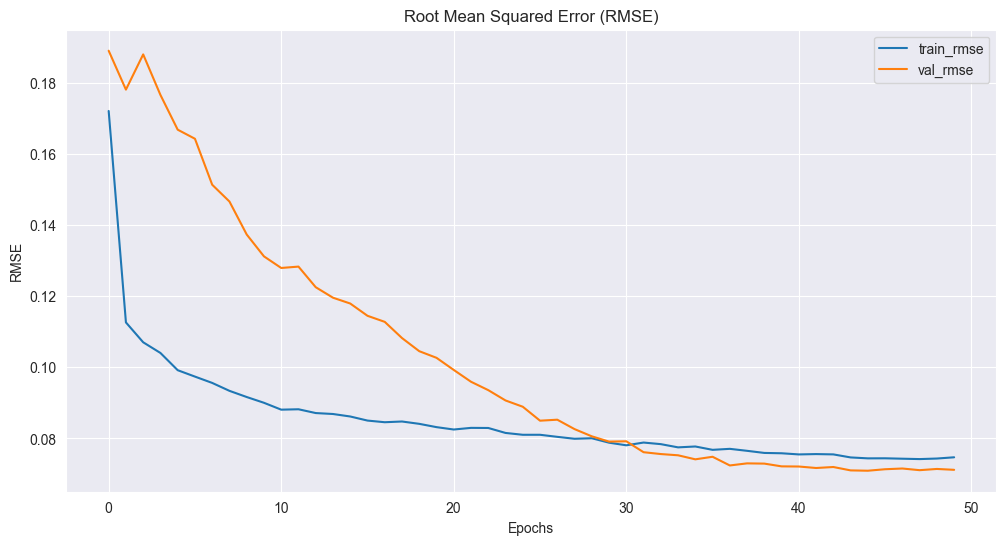

In [291]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# design network

# Define the model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['mae', 'mse', 'mape'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-5)

# Fit the network
history = model.fit(train_X, train_y, epochs=50, batch_size=24, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False,callbacks=[early_stopping, reduce_lr])

# Calculate MAPE manually
# Calculate MAPE manually, handling zero values
def safe_mape(y_true, y_pred, epsilon=1e-10):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100

train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)

train_mape = safe_mape(train_y, train_predictions.squeeze())
test_mape = safe_mape(test_y, test_predictions.squeeze())


print(f'Train MAPE: {train_mape}')
print(f'Test MAPE: {test_mape}')

# Plot history for loss, MAE, and RMSE as before
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.show()

train_rmse = np.sqrt(history.history['mse'])
val_rmse = np.sqrt(history.history['val_mse'])
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='train_rmse')
plt.plot(val_rmse, label='val_rmse')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Root Mean Squared Error (RMSE)')
plt.show()

In [292]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error, mean_absolute_error

yhat = model.predict(test_X)
# print(yhat.shape) # (7442, 1)
# print(yhat)
# 2D [number of samples, number of features]
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# print(test_X.shape) # (7442, 9)
# [number of samples, timesteps, Number of features]

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X), axis=1)  
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0] # first column

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0] # first column

# show the training performance metrics

# calculate RMSE, MAE, MAPE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
MAPE = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % MAPE)

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
Test RMSE: 6.232
Test MAE: 4.911
Test MAPE: 6.744


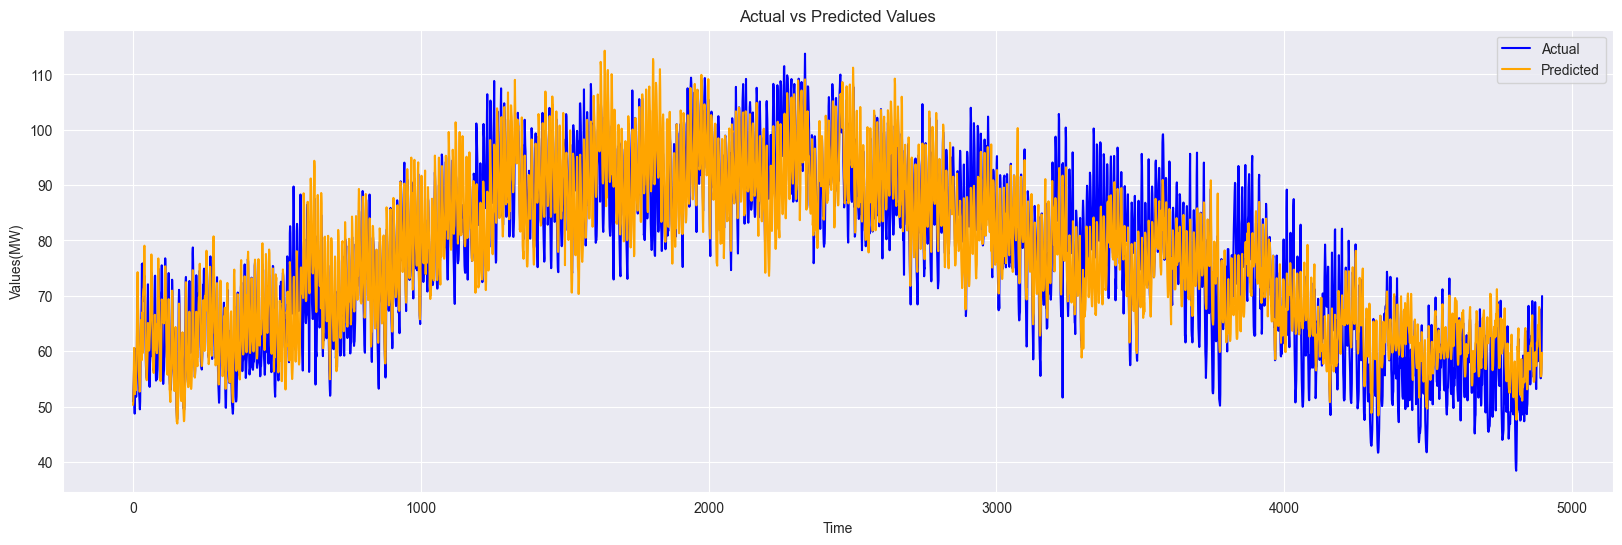

In [293]:
plt.figure(figsize=(20, 6))
plt.plot(inv_y, label='Actual', color='blue')
plt.plot(inv_yhat, label='Predicted', color='orange')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Values(MW)')
plt.legend()
plt.grid(True)
plt.show()

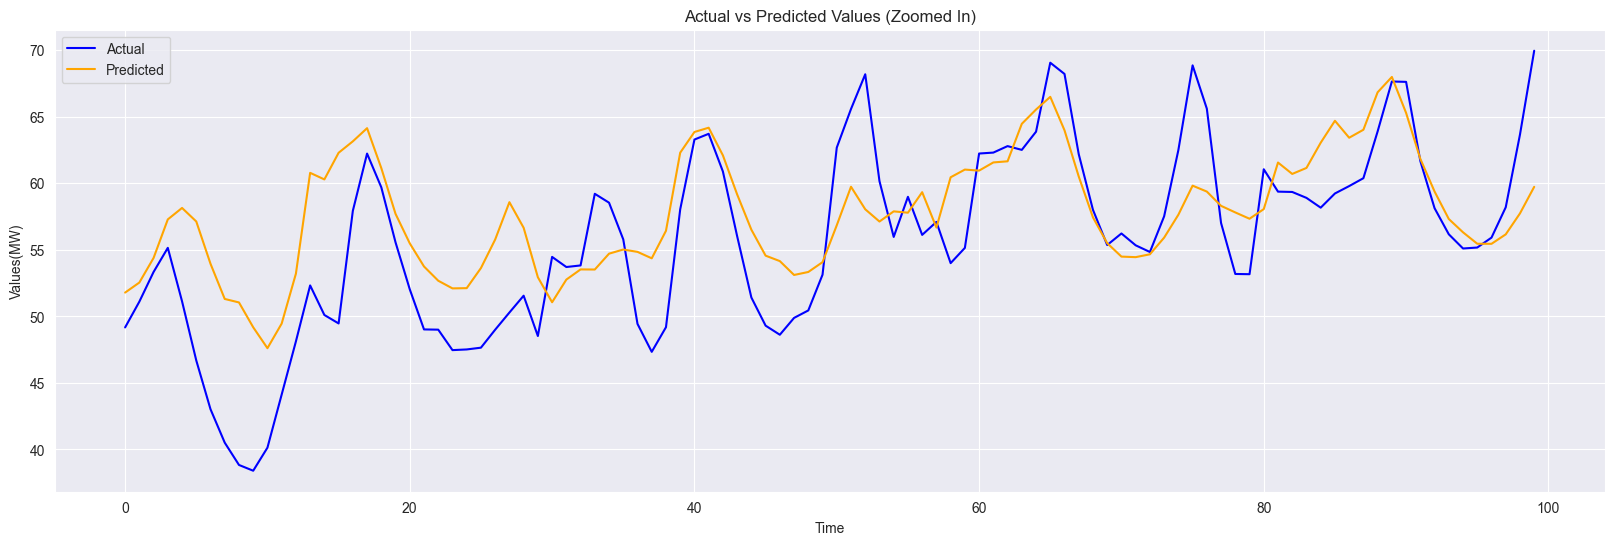

In [294]:
# Zoom in to plot
plt.figure(figsize=(20, 6))
plt.plot(inv_y[-100:], label='Actual', color='blue')
plt.plot(inv_yhat[-100:], label='Predicted', color='orange')
plt.title('Actual vs Predicted Values (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Values(MW)')
plt.legend()
plt.grid(True)
plt.show()


# use the ofs data to predict

In [295]:
# LSTM_df_ofs = LSTM_df.iloc[-2000:, :]
# reshape
ofs_values = LSTM_df_ofs.values
# Split into input and output
ofs_X, ofs_y = ofs_values[:, :-1], ofs_values[:, -1]
# Reshape input to be 3D [number of samples, timesteps, number of features]
ofs_X = ofs_X.reshape((ofs_X.shape[0], 1, ofs_X.shape[1]))
print(ofs_X.shape, ofs_y.shape)

(2000, 1, 14) (2000,)


In [296]:
# Make predictions
ofs_predictions = model.predict(ofs_X)

# Reshape OFS data to original 2D shape for inverse transformation
ofs_X_reshaped = ofs_X.reshape((ofs_X.shape[0], ofs_X.shape[2]))

# Invert scaling for forecast
inv_ofs_predictions = concatenate((ofs_predictions, ofs_X_reshaped), axis=1)
inv_ofs_predictions = scaler.inverse_transform(inv_ofs_predictions)
inv_ofs_predictions = inv_ofs_predictions[:, 0]  # First column

# Invert scaling for actual
ofs_y = ofs_y.reshape((len(ofs_y), 1))
inv_ofs_y = concatenate((ofs_y, ofs_X_reshaped), axis=1)
inv_ofs_y = scaler.inverse_transform(inv_ofs_y)
inv_ofs_y = inv_ofs_y[:, 0]  # First column

# Calculate RMSE, MAE, MAPE
ofs_rmse = sqrt(mean_squared_error(inv_ofs_y, inv_ofs_predictions))
ofs_mae = mean_absolute_error(inv_ofs_y, inv_ofs_predictions)
ofs_mape = np.mean(np.abs((inv_ofs_y - inv_ofs_predictions) / inv_ofs_y)) * 100

print('OFS RMSE: %.3f' % ofs_rmse)
print('OFS MAE: %.3f' % ofs_mae)
print('OFS MAPE: %.3f' % ofs_mape)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
OFS RMSE: 5.707
OFS MAE: 4.341
OFS MAPE: 6.695


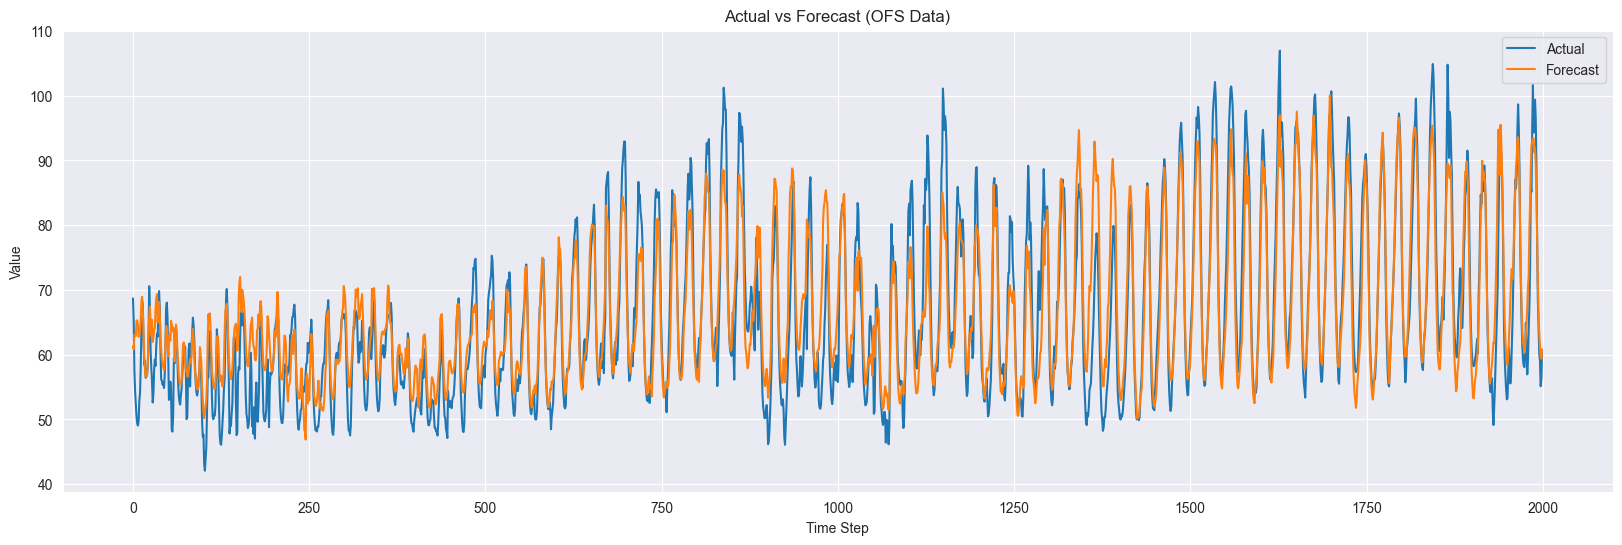

In [297]:
# Plot prediction vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(inv_ofs_y, label='Actual')
plt.plot(inv_ofs_predictions, label='Forecast')
plt.title('Actual vs Forecast (OFS Data)')
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [298]:
# split into train and test sets
values = LSTM_df.values
n_train_hours = 365 * 36
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13140, 1, 14) (13140,) (4897, 1, 14) (4897,)


In [93]:
from keras.optimizers import Adam, SGD
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from math import sqrt
# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

# Function to create the LSTM model
def create_model(units=50, optimizer='adam', learning_rate=0.001):
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
        
    model = Sequential()
    model.add(LSTM(units, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer=optimizer)
    return model

# Function to evaluate model performance
def evaluate_model(train_X, train_y, test_X, test_y, units, batch_size, epochs, optimizer, learning_rate):
    model = create_model(units, optimizer, learning_rate)
    model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False, validation_data=(test_X, test_y))
    
    # Make predictions
    yhat = model.predict(test_X)
    test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    
    # Invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X_reshaped), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    
    # Invert scaling for actual
    test_y_reshaped = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y_reshaped, test_X_reshaped), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    # Calculate RMSE and MAE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    mae = mean_absolute_error(inv_y, inv_yhat)
    mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100
    
    return inv_y, inv_yhat, rmse, mae, mape

# Function to search for the best hyperparameters
def search_best_hyperparameters():
    # Define hyperparameters to test
    units_list = [50, 100, 150]
    batch_size_list = [32, 64, 72]
    epochs_list = [10, 20, 50]
    optimizer_list = ['adam', 'sgd']
    learning_rate_list = [0.001, 0.01, 0.1]

    # Initialize results storage
    results = []

   # Calculate total iterations for tqdm progress bar
    total_iterations = len(units_list) * len(batch_size_list) * len(epochs_list) * len(optimizer_list) * len(learning_rate_list)
    
    # Manually test different hyperparameters with tqdm progress bar
    with tqdm(total=total_iterations, desc="Hyperparameter Search") as pbar:
        for i, (units, batch_size, epochs, optimizer, learning_rate) in enumerate(
            (u, b, e, o, l) 
            for u in units_list 
            for b in batch_size_list 
            for e in epochs_list 
            for o in optimizer_list
            for l in learning_rate_list
        ):
            inv_y, inv_yhat, rmse, mae, mape = evaluate_model(train_X, train_y, test_X, test_y, units, batch_size, epochs, optimizer, learning_rate)
            results.append((units, batch_size, epochs, optimizer, learning_rate, rmse, mae, mape))
            if i % (total_iterations // 5) == 0:  # Update every 5%
                pbar.update(5)
    
    return inv_y, inv_yhat, results

In [94]:
# Search for the best hyperparameters
inv_y, inv_yhat,results = search_best_hyperparameters()

Hyperparameter Search:   0%|          | 0/162 [00:00<?, ?it/s]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Hyperparameter Search:   3%|▎         | 5/162 [00:05<02:58,  1.14s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━

Hyperparameter Search:   6%|▌         | 10/162 [05:16<1:33:50, 37.04s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━

Hyperparameter Search:   9%|▉         | 15/162 [10:25<1:58:32, 48.38s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━

Hyperparameter Search:  12%|█▏        | 20/162 [17:18<2:26:21, 61.84s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━

Hyperparameter Search:  12%|█▏        | 20/162 [24:39<2:55:02, 73.96s/it]


KeyboardInterrupt: 

In [38]:
# Function to train and plot the best model
def train_and_plot_best_model(results, train_X, train_y, test_X, test_y, metric='mae'):
    if metric == 'mae':
        best_result = min(results, key=lambda x: x[6])  # Sort by MAE
    elif metric == 'rmse':
        best_result = min(results, key=lambda x: x[5])  # Sort by RMSE
    elif metric == 'mape':
        best_result = min(results, key=lambda x: x[7])  # Sort by MAPE
    else:
        raise ValueError("Unsupported metric. Use 'mae' or 'rmse' or 'mape'")
    
    print(f"Best hyperparameters: units={best_result[0]}, batch_size={best_result[1]},  epochs={best_result[2]}, optimizer={best_result[3]}, learning_rate={best_result[4]}")
    print(f"Best RMSE={best_result[5]}, Best MAE={best_result[6]}, Best MAPE={best_result[7]}")

    best_units, best_batch_size, best_epochs, best_optimizer, best_learning_rate = best_result[:5]
    model = create_model(best_units, best_optimizer, best_learning_rate)
    history = model.fit(train_X, train_y, epochs=best_epochs, batch_size=best_batch_size, validation_data=(test_X, test_y), verbose=0, shuffle=False)

    # Plot history
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

    # Make final prediction and plot results
    yhat = model.predict(test_X, verbose=0)
    test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # Invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]

    # Invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X_reshaped[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]

    # Plot the actual vs predicted values
    plt.figure(figsize=(20, 6))
    plt.plot(inv_y, label='Actual', color='blue')
    plt.plot(inv_yhat, label='Predicted', color='orange')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Zoom in to plot
    plt.figure(figsize=(20, 6))
    plt.plot(inv_y[-100:], label='Actual', color='blue')
    plt.plot(inv_yhat[-100:], label='Predicted', color='orange')
    plt.title('Actual vs Predicted Values (Zoomed In)')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

Training and plotting best model based on MAE:
Best hyperparameters: units=100, batch_size=64,  epochs=20, optimizer=adam, learning_rate=0.001
Best RMSE=2.8031996801825625, Best MAE=1.9361241173325696, Best MAPE=3.2665640544131964


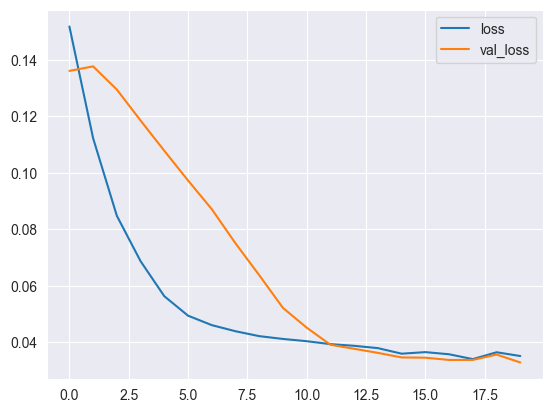

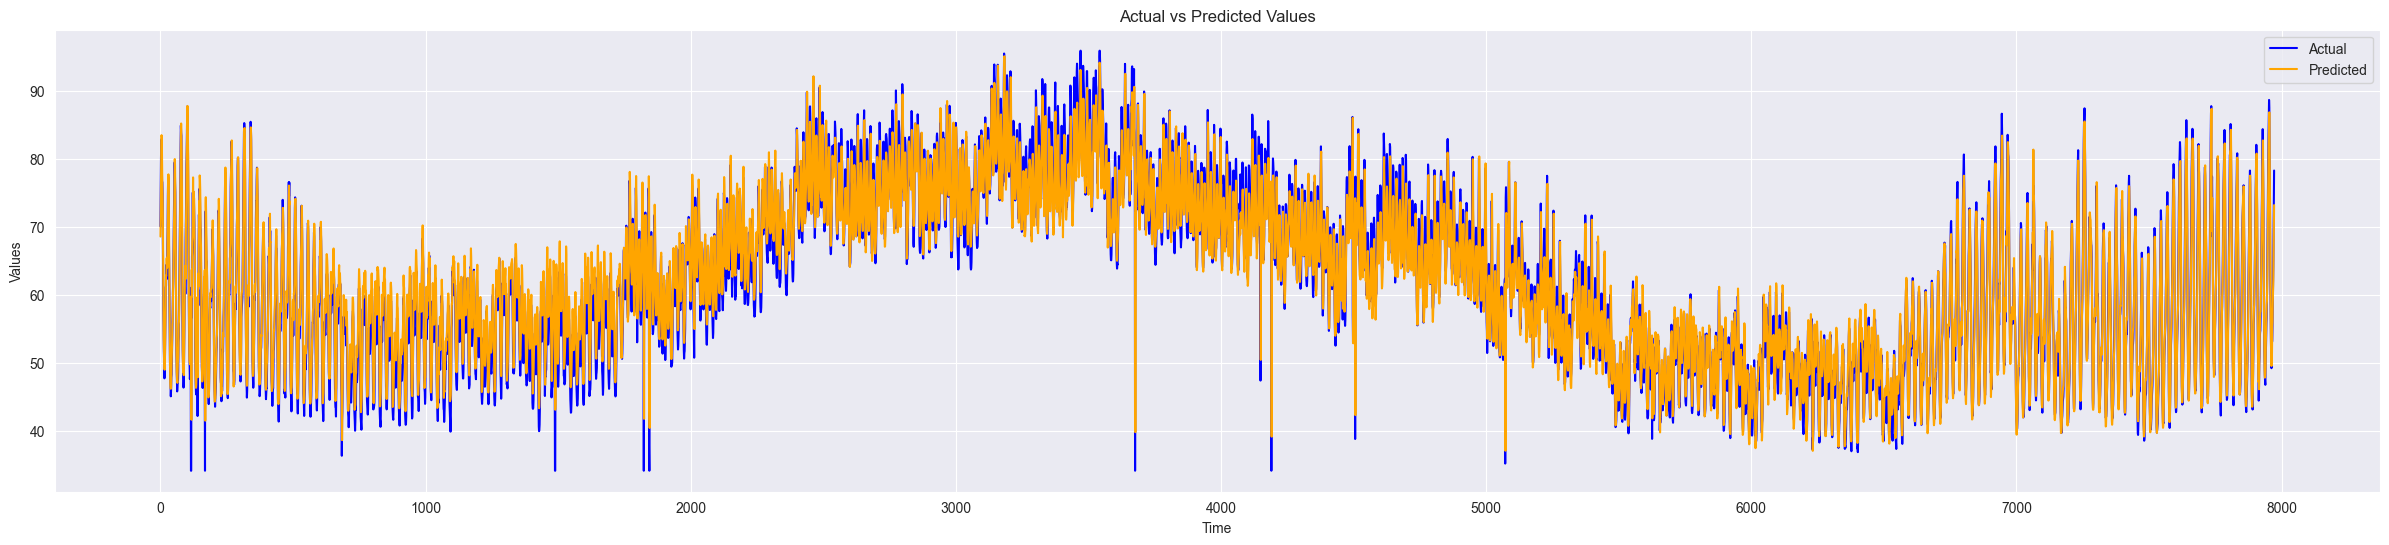

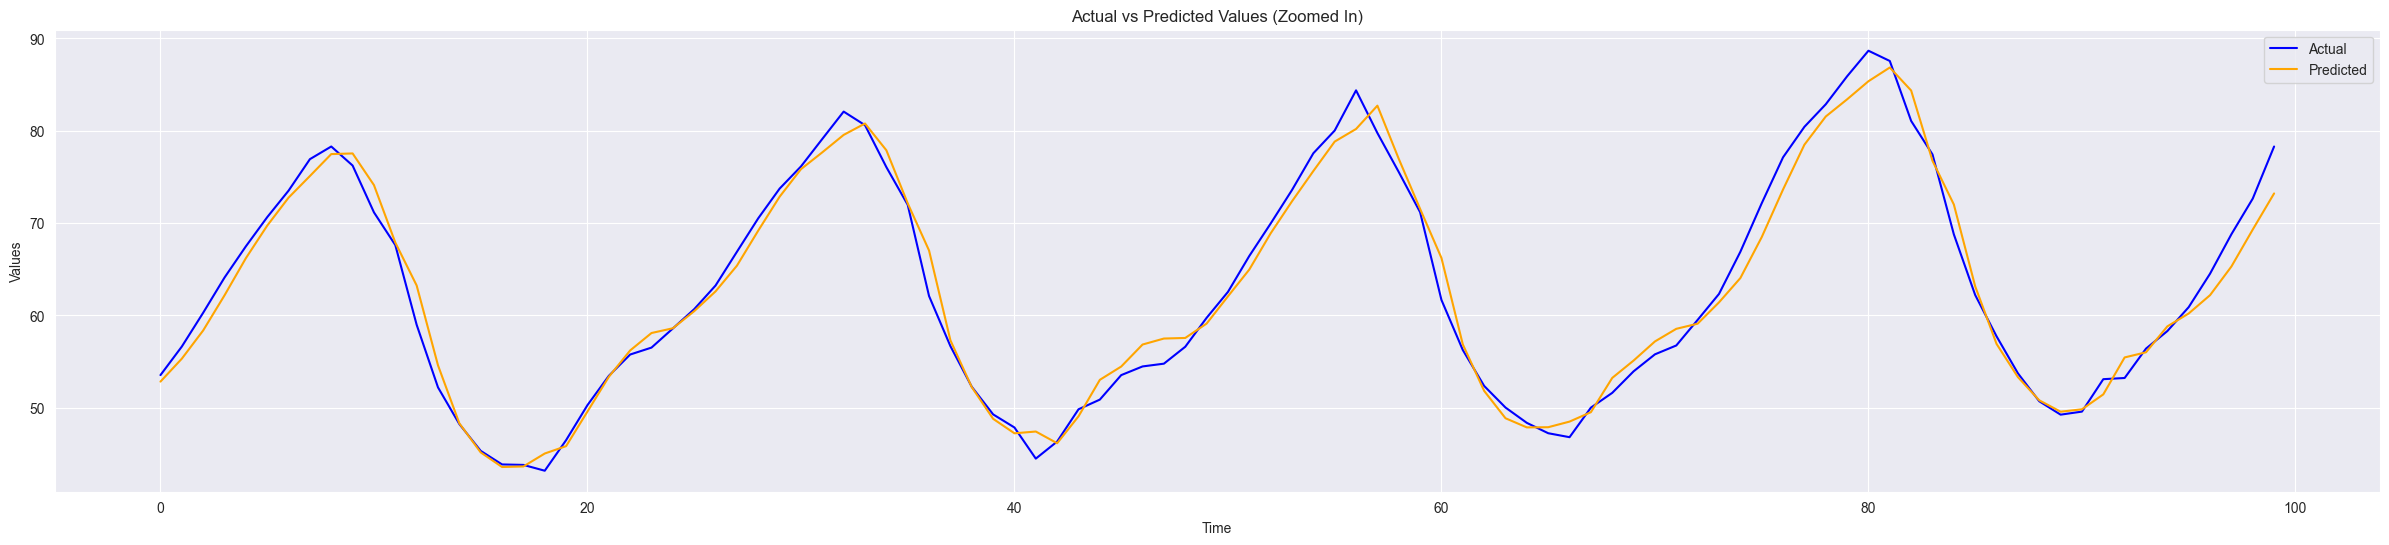

Training and plotting best model based on RMSE:
Best hyperparameters: units=100, batch_size=64,  epochs=20, optimizer=adam, learning_rate=0.001
Best RMSE=2.8031996801825625, Best MAE=1.9361241173325696, Best MAPE=3.2665640544131964


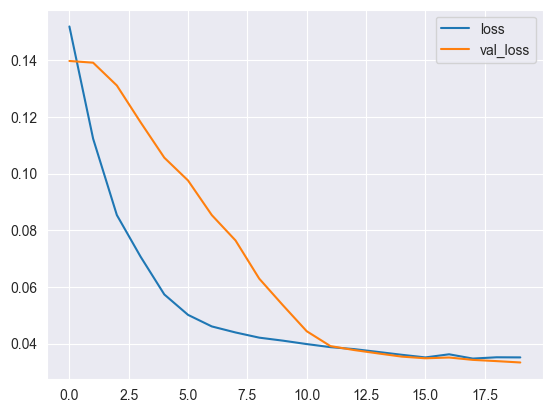

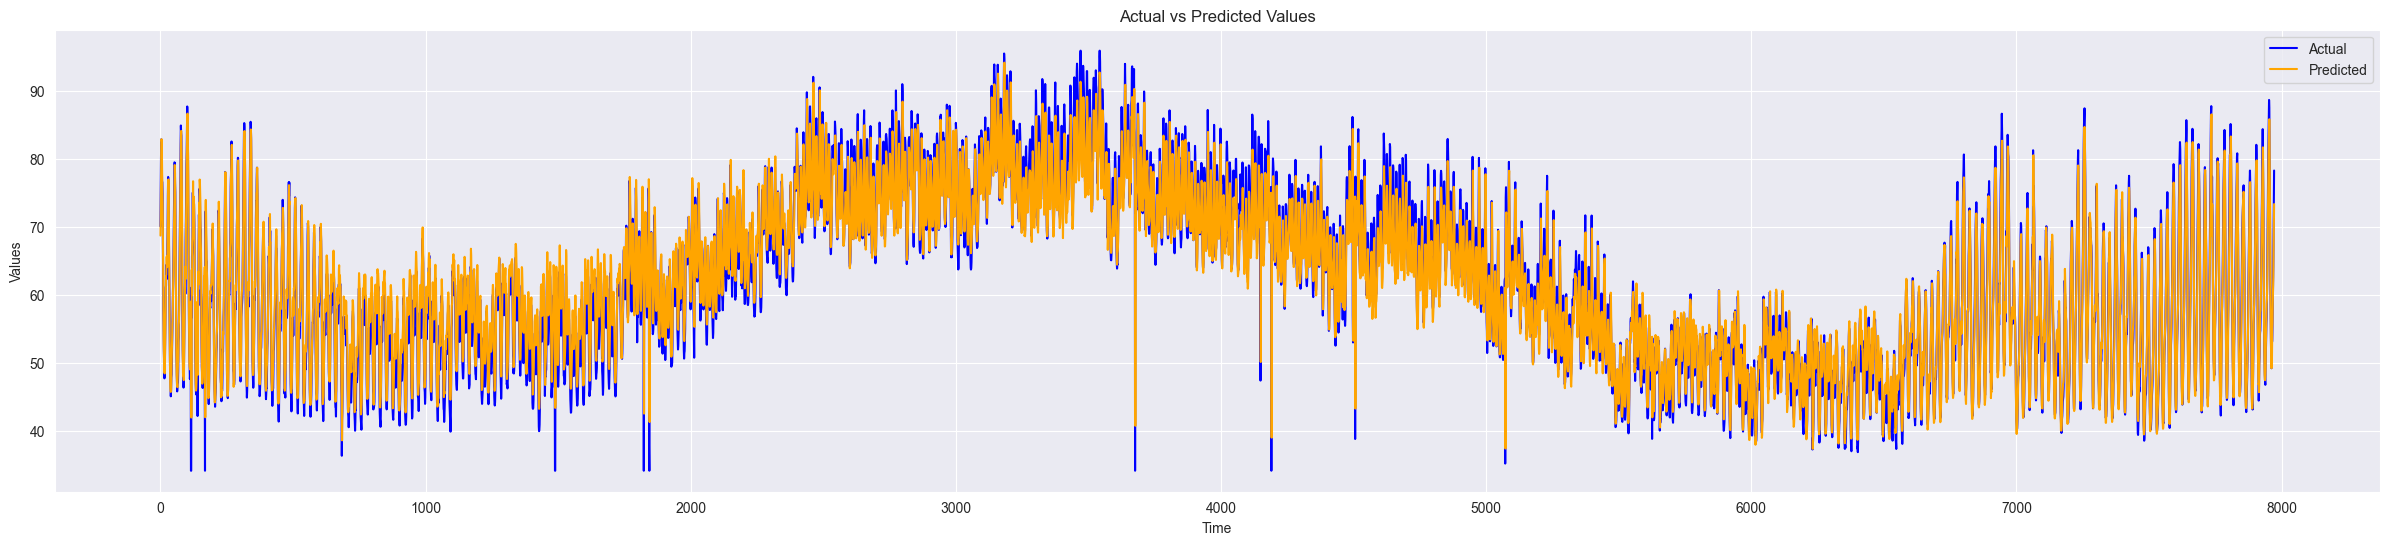

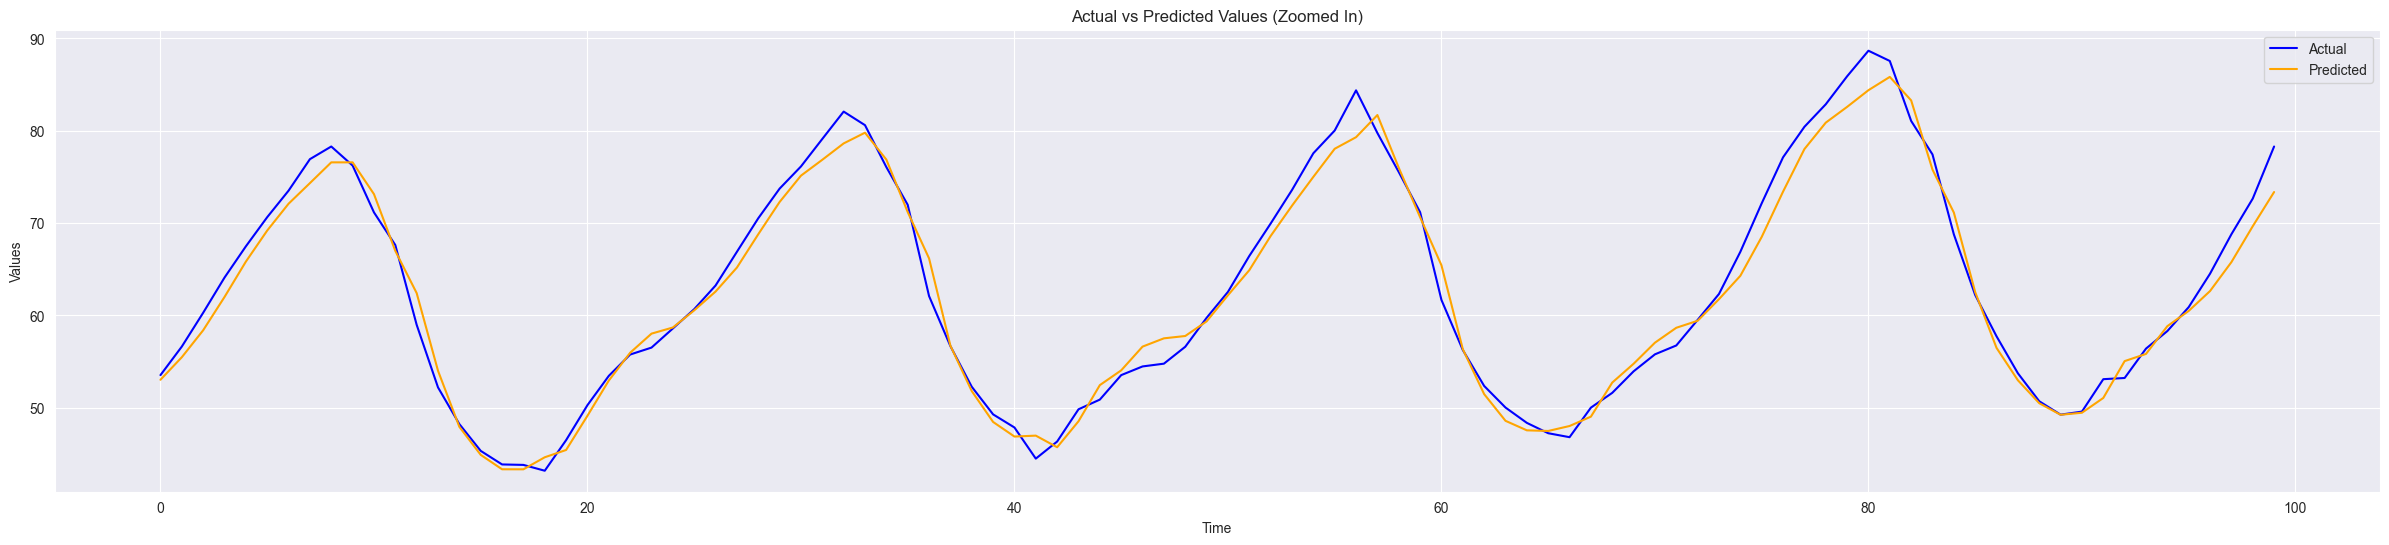

Training and plotting best model based on MAPE:
Best hyperparameters: units=100, batch_size=64,  epochs=20, optimizer=adam, learning_rate=0.001
Best RMSE=2.8031996801825625, Best MAE=1.9361241173325696, Best MAPE=3.2665640544131964


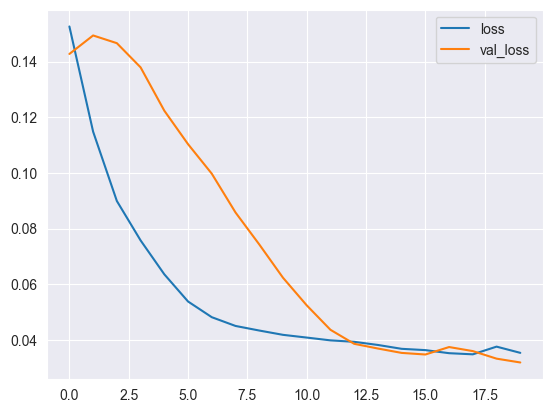

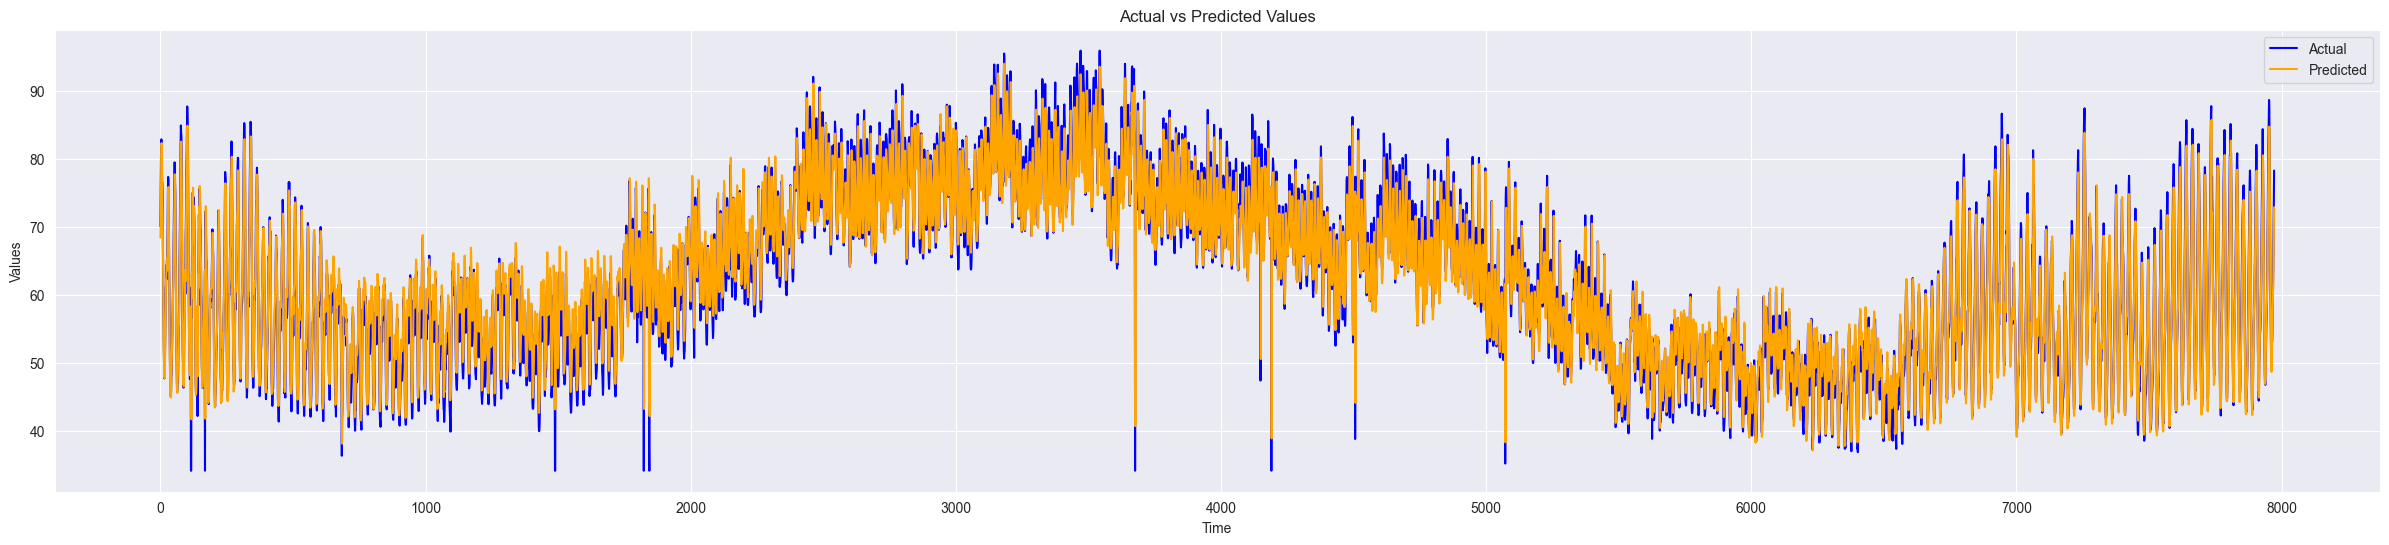

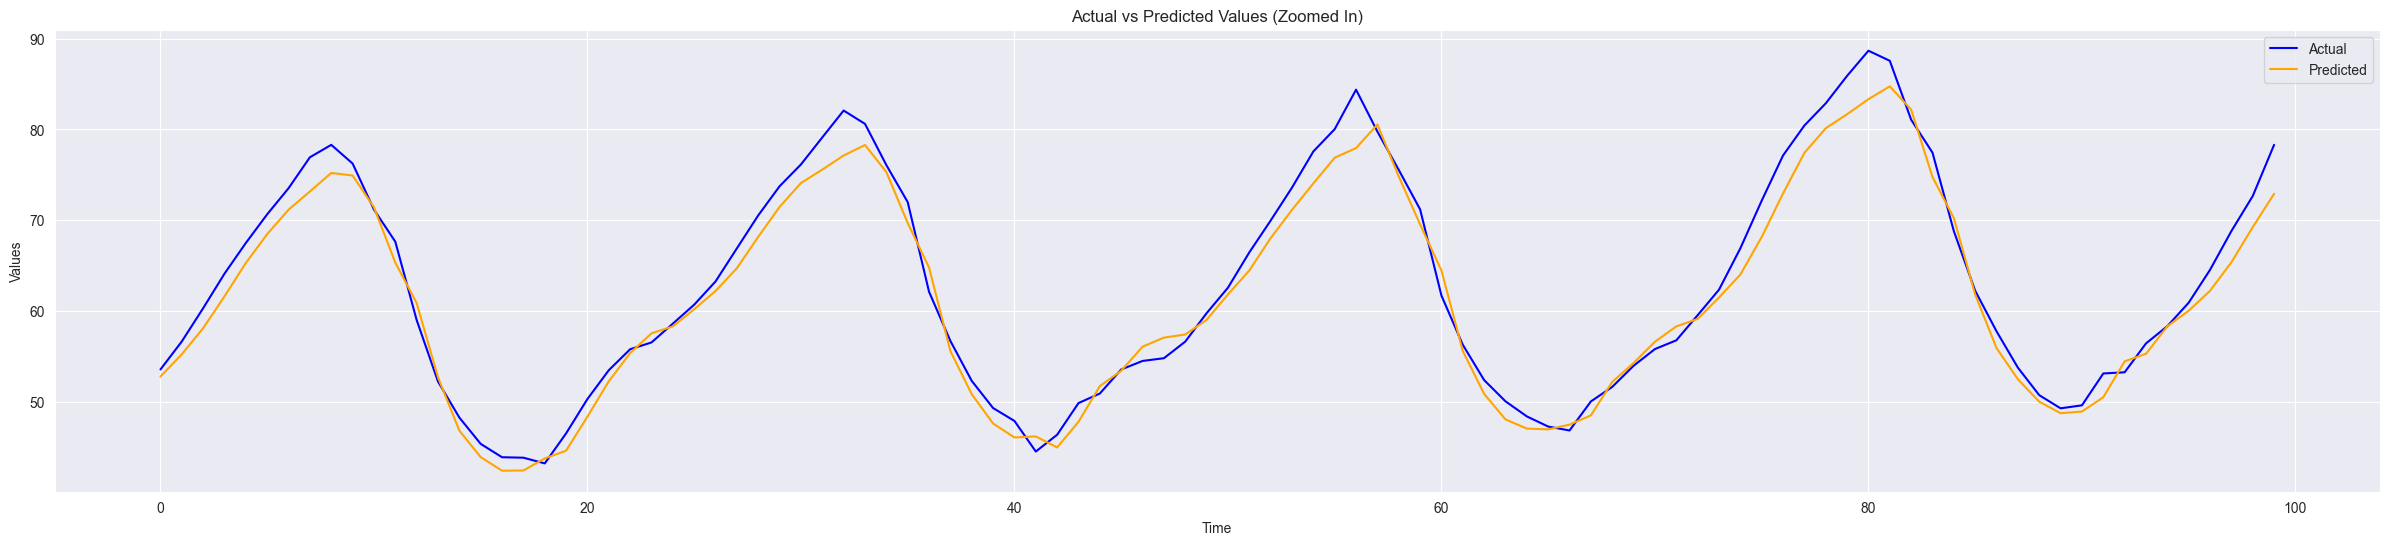

In [39]:
# Train and plot best model based on MAE
print("Training and plotting best model based on MAE:")
best_mae_result = train_and_plot_best_model(results, train_X, train_y, test_X, test_y, metric='mae')

# Train and plot best model based on RMSE
print("Training and plotting best model based on RMSE:")
best_rmse_result = train_and_plot_best_model(results, train_X, train_y, test_X, test_y, metric='rmse')

# Train and plot best model based on MAPE
print("Training and plotting best model based on MAPE:")
best_mape_result = train_and_plot_best_model(results, train_X, train_y, test_X, test_y, metric='mape')

In [102]:
pip install keras-tuner

   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ---------------------------------------- 129.1/129.1 kB 7.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [257]:
# Normalize the data and convert to time series data
from sklearn.preprocessing import MinMaxScaler

df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
df_merged = df_merged.sort_values(by = 'timestamp')
# features and target
df_model = df_merged[['gross_load_replaced', 'gross_load_replaced_3d', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'temperature', 'solar_radiation', 'cloud_cover', 'humidity',
       'wind_speed']]


features = ['gross_load_replaced_3d', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'temperature', 'solar_radiation', 'cloud_cover', 'humidity','wind_speed']
features_to_scale = ['gross_load_replaced_3d', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'temperature', 'solar_radiation', 'cloud_cover', 'humidity','wind_speed']
target_column = ['gross_load_replaced']
#non_scaled_features = ['is_holiday']

columns_to_scale = features_to_scale + target_column

# Scale the feature columns and target column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df_model[columns_to_scale])
LSTM_df = pd.DataFrame(scaled_df, columns=columns_to_scale, index=df_model.index)
LSTM_df

,gross_load_replaced_3d,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,dow_sin,dow_cos,temperature,solar_radiation,cloud_cover,humidity,wind_speed,gross_load_replaced
74,0.270997,0.5,1.0,0.050521,0.277951,0.066987,0.750000,0.000000,0.356896,0.320563,0.257023,0.500268,0.441337,0.039796,0.565371
75,0.610973,0.5,1.0,0.050521,0.277951,0.146447,0.853553,0.000000,0.356896,0.321561,0.463028,0.126753,0.409061,0.008701,0.550908
76,0.638824,0.5,1.0,0.050521,0.277951,0.250000,0.933013,0.000000,0.356896,0.322607,0.350211,0.019385,0.388261,0.033653,0.553307
77,0.687832,0.5,1.0,0.050521,0.277951,0.370590,0.982963,0.000000,0.356896,0.322655,0.193267,0.003273,0.350356,0.129865,0.587788
78,0.768096,0.5,1.0,0.015339,0.373065,0.500000,1.000000,0.099031,0.801938,0.321121,0.026591,0.000000,0.352669,0.114282,0.678449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20859,0.292012,0.5,0.0,0.399221,0.989739,0.982963,0.370590,1.000000,0.356896,0.340667,0.000000,0.000000,0.097673,0.298747,0.352399
20860,0.259310,0.5,0.0,0.399221,0.989739,0.933013,0.250000,1.000000,0.356896,0.339580,0.000000,0.000000,0.097212,0.294748,0.340929
20861,0.234447,0.5,0.0,0.399221,0.989739,0.853553,0.146447,1.000000,0.356896,0.338643,0.000000,0.000000,0.102409,0.247467,0.295365
20862,0.225927,0.5,0.0,0.399221,0.989739,0.750000,0.066987,1.000000,0.356896,0.336531,0.000000,0.000000,0.131287,0.248050,0.308721


In [258]:
# split into train and test sets
values = LSTM_df.values
n_train_hours = 365 * 36
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]  # x: All columns except the last,  y: The last column
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [number of samples, timesteps, Number of features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13140, 1, 14) (13140,) (6897, 1, 14) (6897,)


In [259]:
import shutil

# Delete the previous tuner directory
shutil.rmtree('hyperparameter_tuning/lstm_tuning', ignore_errors=True)

In [260]:
from keras_tuner import RandomSearch, GridSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt



# Function to create the LSTM model
def create_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=150, step=50),
                   input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01, 0.1]))
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=hp.Choice('learning_rate', [0.001, 0.01, 0.1]))

    model.compile(loss='mape', optimizer='adam', metrics=['mape'])

    return model

# Define the tuner
tuner = GridSearch(
    create_model,
    objective='val_loss',
    max_trials=80,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='lstm_tuning'
)

# # Add batch_size to the search space
tuner.search_space_summary()


# Define early stopping and reduce learning rate on plateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-5)

# Conduct the search
tuner.search(train_X, train_y,
             epochs=HyperParameters().Int('epochs', min_value=20, max_value=80, step=20),
             batch_size=HyperParameters().Int('batch_size', min_value=16, max_value=48, step=16),
             validation_data=(test_X, test_y),
             callbacks=[early_stopping, reduce_lr],
             verbose=2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\nBest hyperparameters:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

Trial 54 Complete [00h 00m 27s]
val_loss: 1367918208.0

Best val_loss So Far: 13.883155822753906
Total elapsed time: 00h 16m 00s

Best hyperparameters:
units: 100
dropout: 0.4
optimizer: adam
learning_rate: 0.001


In [263]:
best_epochs = best_hps.Int('epochs', min_value=10, max_value=100, step=20)
best_batch_size = best_hps.Int('batch_size', min_value=32, max_value=72, step=32)
print(f"Best epochs: {best_epochs}, Best batch size: {best_batch_size}")

Best epochs: 10, Best batch size: 32


Epoch 1/50
411/411 - 2s - 6ms/step - loss: 25250.7031 - mape: 25250.7031 - val_loss: 14.9419 - val_mape: 14.9419 - learning_rate: 0.0010
Epoch 2/50
411/411 - 1s - 1ms/step - loss: 22896.5234 - mape: 22896.5234 - val_loss: 14.8724 - val_mape: 14.8724 - learning_rate: 0.0010
Epoch 3/50
411/411 - 0s - 1ms/step - loss: 27113.9629 - mape: 27113.9629 - val_loss: 22.3324 - val_mape: 22.3324 - learning_rate: 0.0010
Epoch 4/50
411/411 - 1s - 1ms/step - loss: 1481.4336 - mape: 1481.4336 - val_loss: 27.0284 - val_mape: 27.0284 - learning_rate: 0.0010
Epoch 5/50
411/411 - 1s - 1ms/step - loss: 12974.8711 - mape: 12974.8711 - val_loss: 45.1224 - val_mape: 45.1224 - learning_rate: 0.0010
Epoch 6/50
411/411 - 1s - 2ms/step - loss: 54503.2227 - mape: 54503.2227 - val_loss: 26.8600 - val_mape: 26.8600 - learning_rate: 0.0010
Epoch 7/50
411/411 - 1s - 2ms/step - loss: 50167.4570 - mape: 50167.4570 - val_loss: 18.2636 - val_mape: 18.2636 - learning_rate: 0.0010


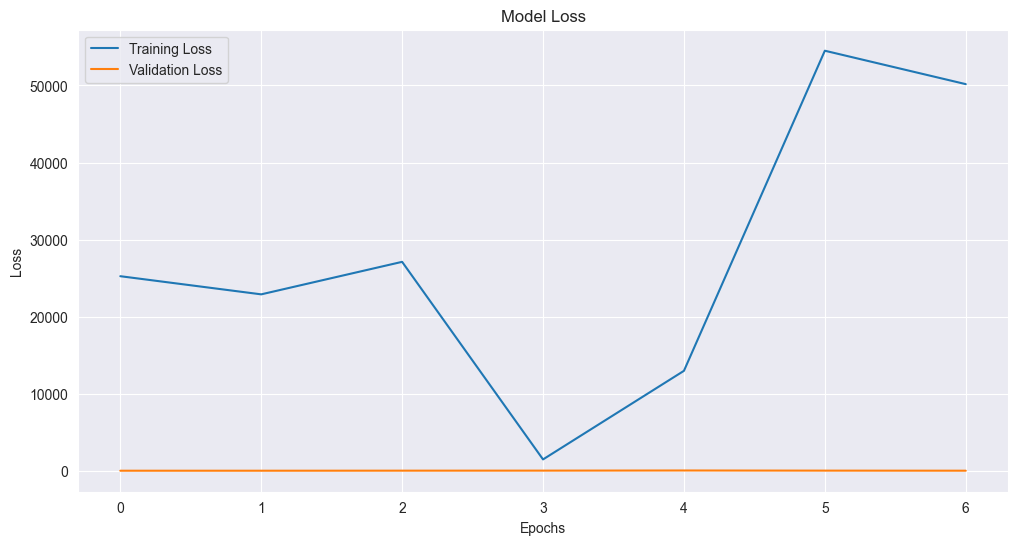

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
RMSE: 7.497847291300725, MAE: 5.844048972125491, MAPE: 8.175094279377848


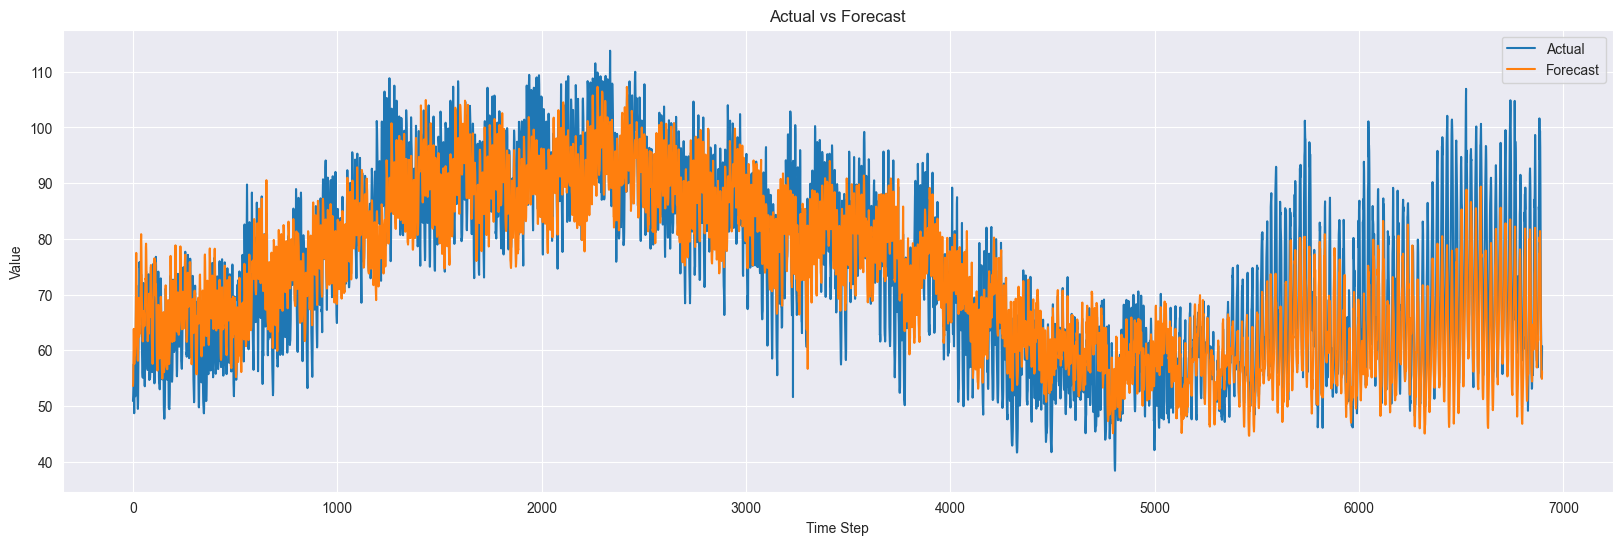

In [264]:
# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_X, train_y,
                    epochs= 50, # best_hps.Int('epochs', min_value=10, max_value=100, step=20),
                    batch_size= 32, #best_hps.Int('batch_size', min_value=32, max_value=72, step=32),
                    validation_data=(test_X, test_y),
                    callbacks=[early_stopping, reduce_lr],
                    verbose=2)

# Plot the loss history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Evaluate the model
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_reshaped), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# Invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_reshaped, test_X_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

# Calculate RMSE, MAE, MAPE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print(f'RMSE: {rmse}, MAE: {mae}, MAPE: {mape}')

# Plot prediction vs actual
plt.figure(figsize=(20, 6))
plt.plot(inv_y, label='Actual')
plt.plot(inv_yhat, label='Forecast')
plt.title('Actual vs Forecast')
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [112]:
# Function to create the LSTM model
def create_model(hp):
    model = Sequential()
    
    # Adding multiple LSTM layers with tunable units
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(LSTM(units=hp.Int(f'units_{i}', min_value=50, max_value=150, step=50),
                       return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False,
                       input_shape=(train_X.shape[1], train_X.shape[2]) if i == 0 else None))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(1))
    
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01, 0.1]))
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=hp.Choice('learning_rate', [0.001, 0.01, 0.1]))

    model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    return model

# Define the tuner
tuner = RandomSearch(
    create_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='lstm_tuning'
)

# Add batch_size to the search space
hp = HyperParameters()
hp.Int('batch_size', min_value=32, max_value=72, step=32)

# Define early stopping and reduce learning rate on plateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

# Conduct the search
tuner.search(train_X, train_y,
             epochs=50,
             batch_size=hp.Int('batch_size', min_value=32, max_value=72, step=32),
             validation_data=(test_X, test_y),
             callbacks=[early_stopping, reduce_lr],
             verbose=2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Reloading Tuner from hyperparameter_tuning\lstm_tuning\tuner0.json


In [114]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Function to create the LSTM model
def create_model(hp):
    model = Sequential()
    
    # Adding multiple LSTM layers with tunable units
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(LSTM(units=hp.Int(f'units_{i}', min_value=50, max_value=150, step=50),
                       return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False,
                       input_shape=(train_X.shape[1], train_X.shape[2]) if i == 0 else None))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(1))
    
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01, 0.1]))
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=hp.Choice('learning_rate', [0.001, 0.01, 0.1]))

    model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    return model

# Define the tuner
tuner = RandomSearch(
    create_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='lstm_tuning'
)

# Add batch_size to the search space
hp = HyperParameters()
hp.Int('batch_size', min_value=32, max_value=72, step=32)

# Define early stopping and reduce learning rate on plateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

# Conduct the search
tuner.search(train_X, train_y,
             epochs=50,
             batch_size=hp.Int('batch_size', min_value=32, max_value=72, step=32),
             validation_data=(test_X, test_y),
             callbacks=[early_stopping, reduce_lr],
             verbose=2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_X, train_y,
                    epochs=50,
                    batch_size=best_hps.get('batch_size'),
                    validation_data=(test_X, test_y),
                    callbacks=[early_stopping, reduce_lr],
                    verbose=2)

# Evaluate the model
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_reshaped), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# Invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_reshaped, test_X_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

# Calculate RMSE, MAE, MAPE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print(f'RMSE: {rmse}, MAE: {mae}, MAPE: {mape}')


Reloading Tuner from hyperparameter_tuning\lstm_tuning\tuner0.json


KeyError: 'batch_size does not exist.'

# cross validation 